In [1]:
import numpy as np
import pandas as pd

from hyperopt import hp

In [4]:
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score 
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import joblib
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

import lightgbm as lgb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

from time import time

In [5]:
df = pd.read_pickle('./data/rename_x1_class.pkl_gz', compression='gzip')
df

,nrow,objID,ra,dec,zspec,zspec_conf,zspec_source,class,subclass,class1,...,zoo_best-x1_ci1a_90_Lx_err,zoo_best-x1_ci1b_90_Lx_err,zoo_best-x1_ci1a_95,zoo_best-x1_ci1b_95,zoo_best-x1_ci1a_95_DL_cm,zoo_best-x1_ci1b_95_DL_cm,zoo_best-x1_ci1a_95_Lx,zoo_best-x1_ci1b_95_Lx,zoo_best-x1_ci1a_95_Lx_err,zoo_best-x1_ci1b_95_Lx_err
0,765558,166771828504836546,182.850396,48.979910,0.046132,-999.0,SDSS,3,STARFORMING,,...,NaN,NaN,-0.023962,0.026538,NaN,NaN,NaN,NaN,NaN,NaN
1,295976,140921926169192374,192.616971,27.434890,0.021385,-999.0,SDSS,3,BROADLINE,,...,NaN,NaN,-0.015042,0.014692,NaN,NaN,NaN,NaN,NaN,NaN
5,267711,153541551169831903,155.117013,37.951053,0.046178,-999.0,SDSS,3,N/A,,...,NaN,NaN,-0.023886,0.025979,NaN,NaN,NaN,NaN,NaN,NaN
6,94182,120741855100415434,185.510020,10.620819,0.025434,-999.0,SDSS,3,STARFORMING,,...,NaN,NaN,-0.017423,0.074669,NaN,NaN,NaN,NaN,NaN,NaN
11,476230,114671598619635888,159.861973,5.562852,0.028537,-999.0,SDSS,3,STARFORMING,,...,NaN,NaN,-0.027526,0.020971,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60414,960359,1237668503831839169,252.083230,50.783279,NaN,NaN,NaN,1,NaN,NaN,...,NaN,NaN,-0.451445,0.228902,NaN,NaN,NaN,NaN,NaN,NaN
60415,960360,1237665583790752642,252.201060,50.891273,NaN,NaN,NaN,1,NaN,NaN,...,NaN,NaN,-0.212508,2.934748,NaN,NaN,NaN,NaN,NaN,NaN
60416,960361,1237665584327361688,252.358160,51.708907,NaN,NaN,NaN,1,NaN,NaN,...,NaN,NaN,-0.855885,1.92245,NaN,NaN,NaN,NaN,NaN,NaN
60417,960362,1237665584327164382,252.128200,52.155919,NaN,NaN,NaN,1,NaN,NaN,...,NaN,NaN,-0.246795,2.79586,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
features_path = '../../models_before_aggregation_j/features.pkl'
column = 'J'
j_features = ['J']
features = pd.read_pickle(features_path) + j_features

In [10]:
for i in df.columns:
    print(i)

nrow
objID
ra
dec
zspec
zspec_conf
zspec_source
class
subclass
class1
class2
origin
Fx
in_XXLN
in_S82X
in_LH
is_12-SDSSunWISE
is_X
u
g
r
i
z
Lw1
Lw2
uM
gM
rM
iM
zM
ra_sdssdr16
dec_sdssdr16
distance
ra_dr16
dec_dr16
objID_sdssdr16
mjd
b
l
extinction_u
extinction_g
extinction_r
extinction_i
extinction_z
psfMag_u
psfMag_g
psfMag_r
psfMag_i
psfMag_z
cModelMag_u
cModelMag_g
cModelMag_r
cModelMag_i
cModelMag_z
psfFlux_u
psfFluxIvar_u
psfFlux_g
psfFluxIvar_g
psfFlux_r
psfFluxIvar_r
psfFlux_i
psfFluxIvar_i
psfFlux_z
psfFluxIvar_z
cModelFlux_u
cModelFluxIvar_u
cModelFlux_g
cModelFluxIvar_g
cModelFlux_r
cModelFluxIvar_r
cModelFlux_i
cModelFluxIvar_i
cModelFlux_z
cModelFluxIvar_z
w1_nanomaggies
w1_nanomaggies_ivar
w2_nanomaggies
w2_nanomaggies_ivar
ra_psdr2
dec_psdr2
distance_psdr2
objID_psdr2
raStack
decStack
raStackErr
decStackErr
objInfoFlag
qualityFlag
nDetections
primaryDetection
bestDetection
gKronFluxErr_min_error
gKronFlux_min_error
rKronFluxErr_min_error
rKronFlux_min_error
iKronFluxErr_

Будем смотреть на слкдующие признаки:

In [11]:
feat = """
ps_gKronFlux
ps_gKronFluxErr
ps_rKronFlux
ps_rKronFluxErr
ps_iKronFlux
ps_iKronFluxErr
ps_zKronFlux
ps_zKronFluxErr
ps_yKronFlux
ps_yKronFluxErr
ps_gPSFFlux
ps_gPSFFluxErr
ps_rPSFFlux
ps_rPSFFluxErr
ps_iPSFFlux
ps_iPSFFluxErr
ps_zPSFFlux
ps_zPSFFluxErr
ps_yPSFFlux
ps_yPSFFluxErr
""".split('\n')[1:-1]

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
color = sns.color_palette()
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.tools as tls

%matplotlib inline

In [42]:
p = df['ebv'].dropna()
np.min(np.log10(p)), np.max(np.log10(p))

(-2.6345671590836655, -0.29325251562371346)

In [84]:
def plotik(p, x, y):
    plt.title(x + ' and ' + y)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.xlim([-0.01, 0.04])
    plt.scatter(p[x],p[y], c='r')
    plt.show()

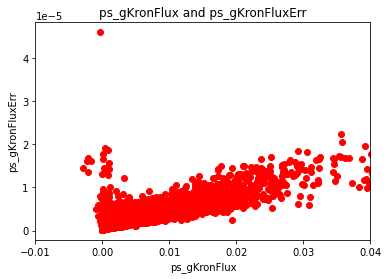

In [85]:
plotik(df, feat[0], feat[1])

Видим практически линейную зависимость. Ее можно предсказать с помощью линейных моделей или ближайших соседей

In [108]:
def plotik_ax(p, x, y, ax):
    ax.set_title(x + ' and ' + y)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_xlim([-0.01, 0.07])
    ax.set_ylim([-0.1, 7])
    ax.scatter(p[x],p[y] / 0.00001, c='r')
    return ax

In [109]:
len(feat)

20

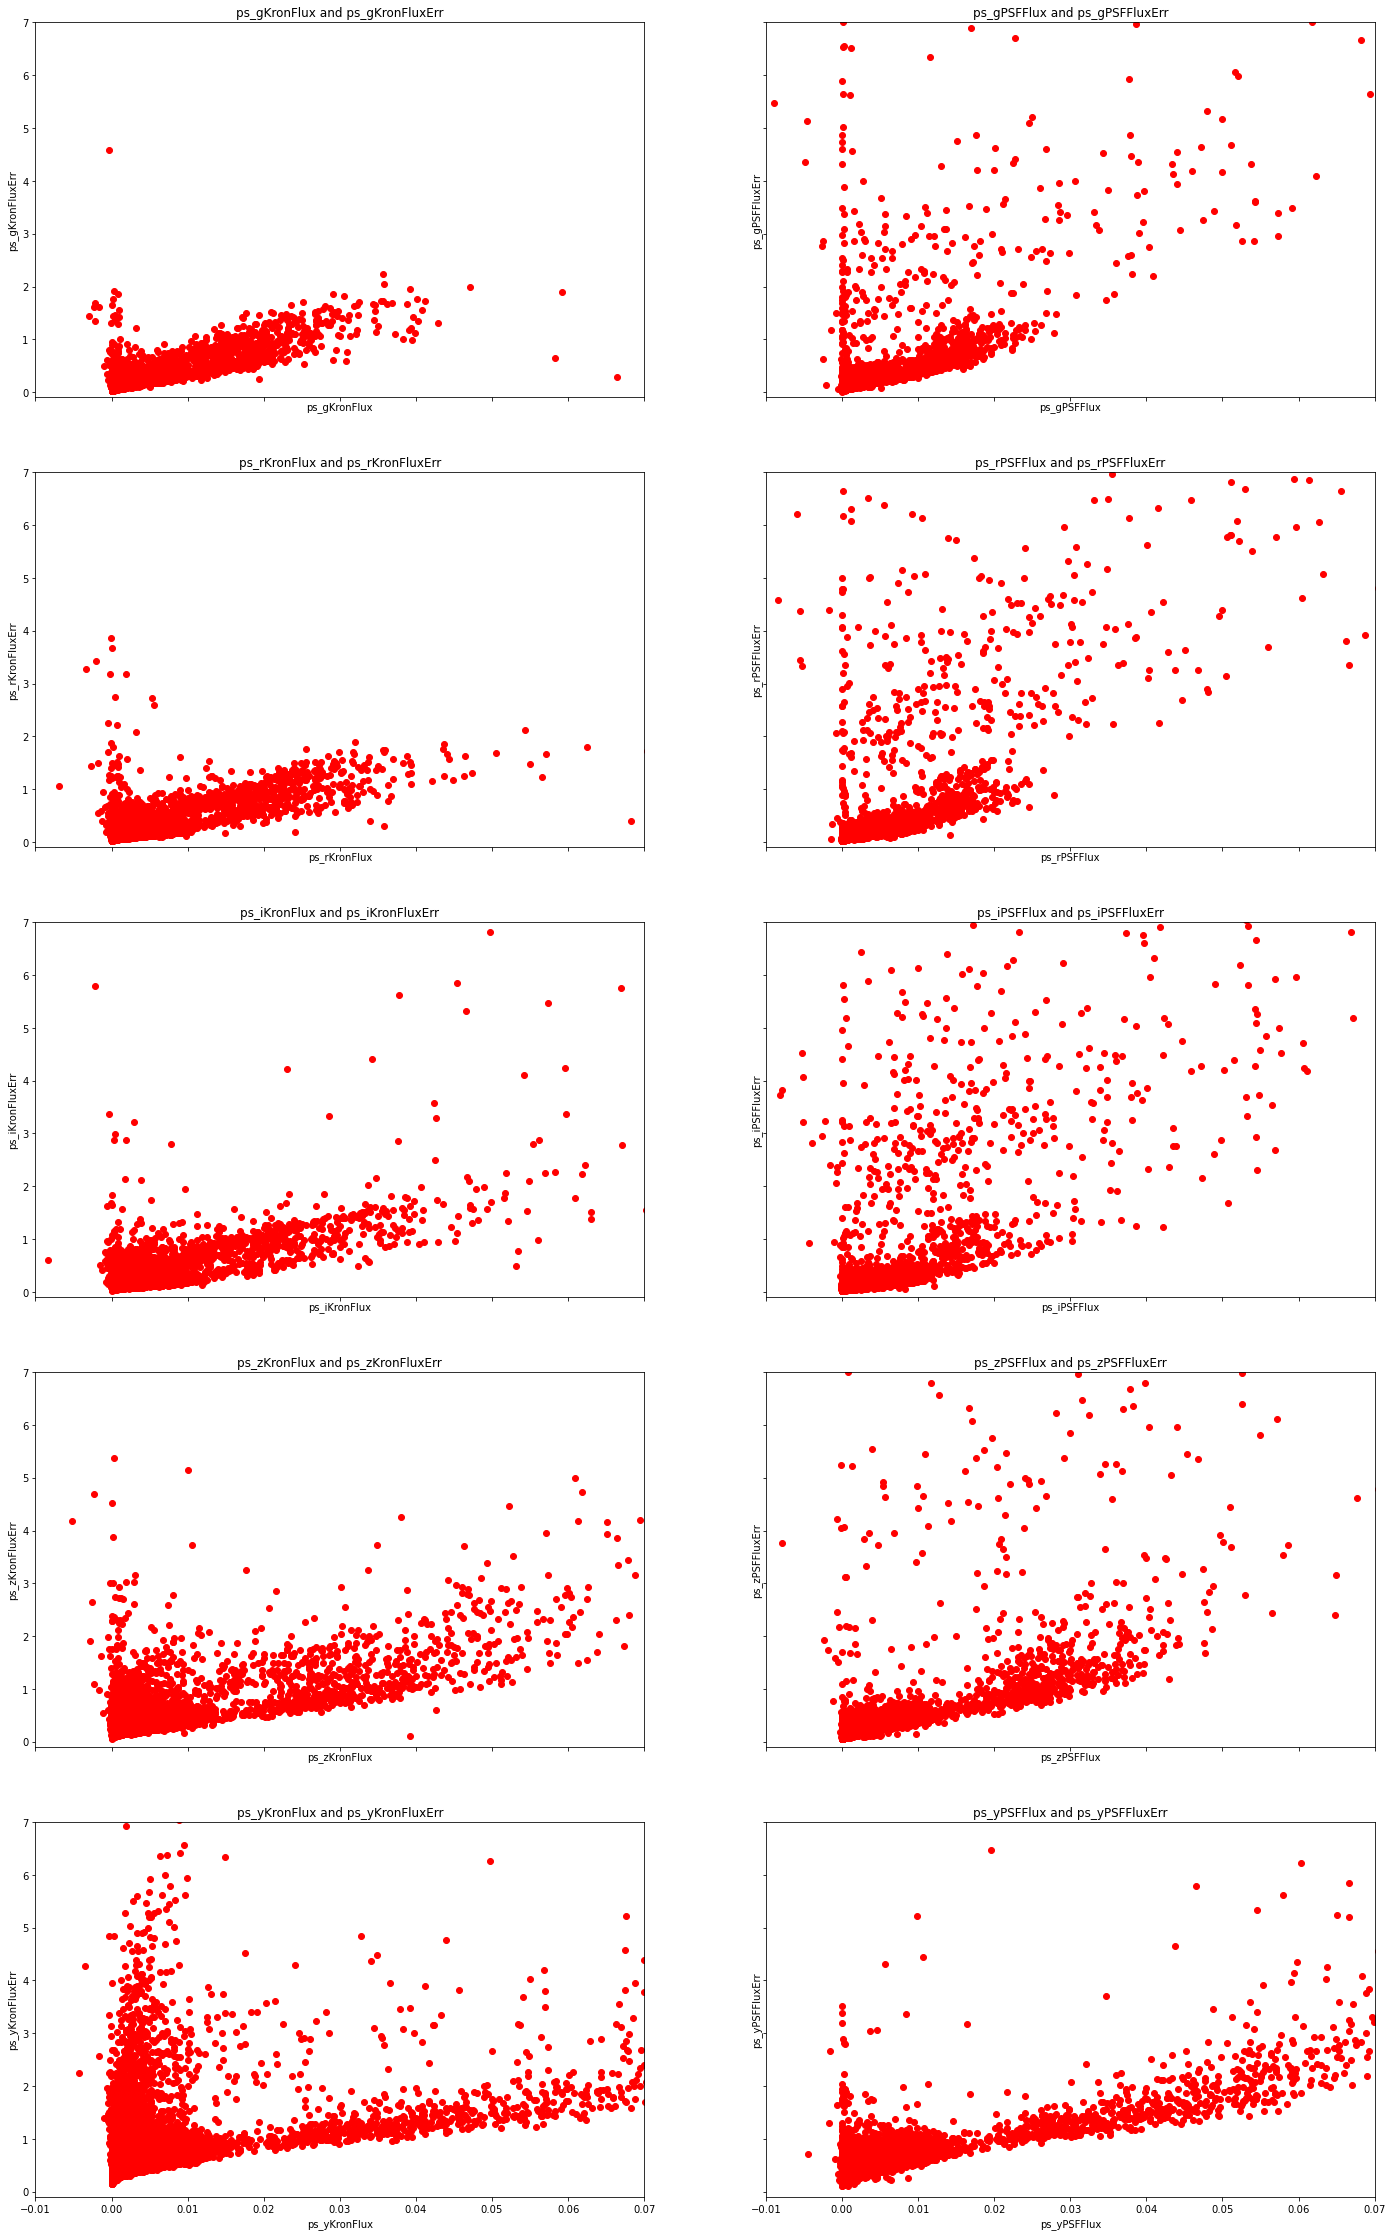

In [110]:
f, axes = plt.subplots(nrows = 5, ncols=2, figsize=(24, 40), sharex=True, sharey = True)
for i in range(len(feat) // 2):
    ax = axes[i % 5][i // 5]
    plotik_ax(df, feat[i*2], feat[i*2 + 1], ax)

In [98]:
from sklearn.linear_model import LinearRegression
df1 = df[feat[:2]].dropna()
X = df1[[feat[0]]]
y = df1[[feat[1]]]
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.08882231262606133

In [99]:
reg.score(X, y)

0.08882231262606133

In [102]:
reg.predict(X)

array([[7.07974121e-07],
       [7.06454279e-07],
       [7.05561870e-07],
       ...,
       [7.05646040e-07],
       [7.06157445e-07],
       [7.05552395e-07]])

In [101]:
reg.intercept_

array([7.05355981e-07])

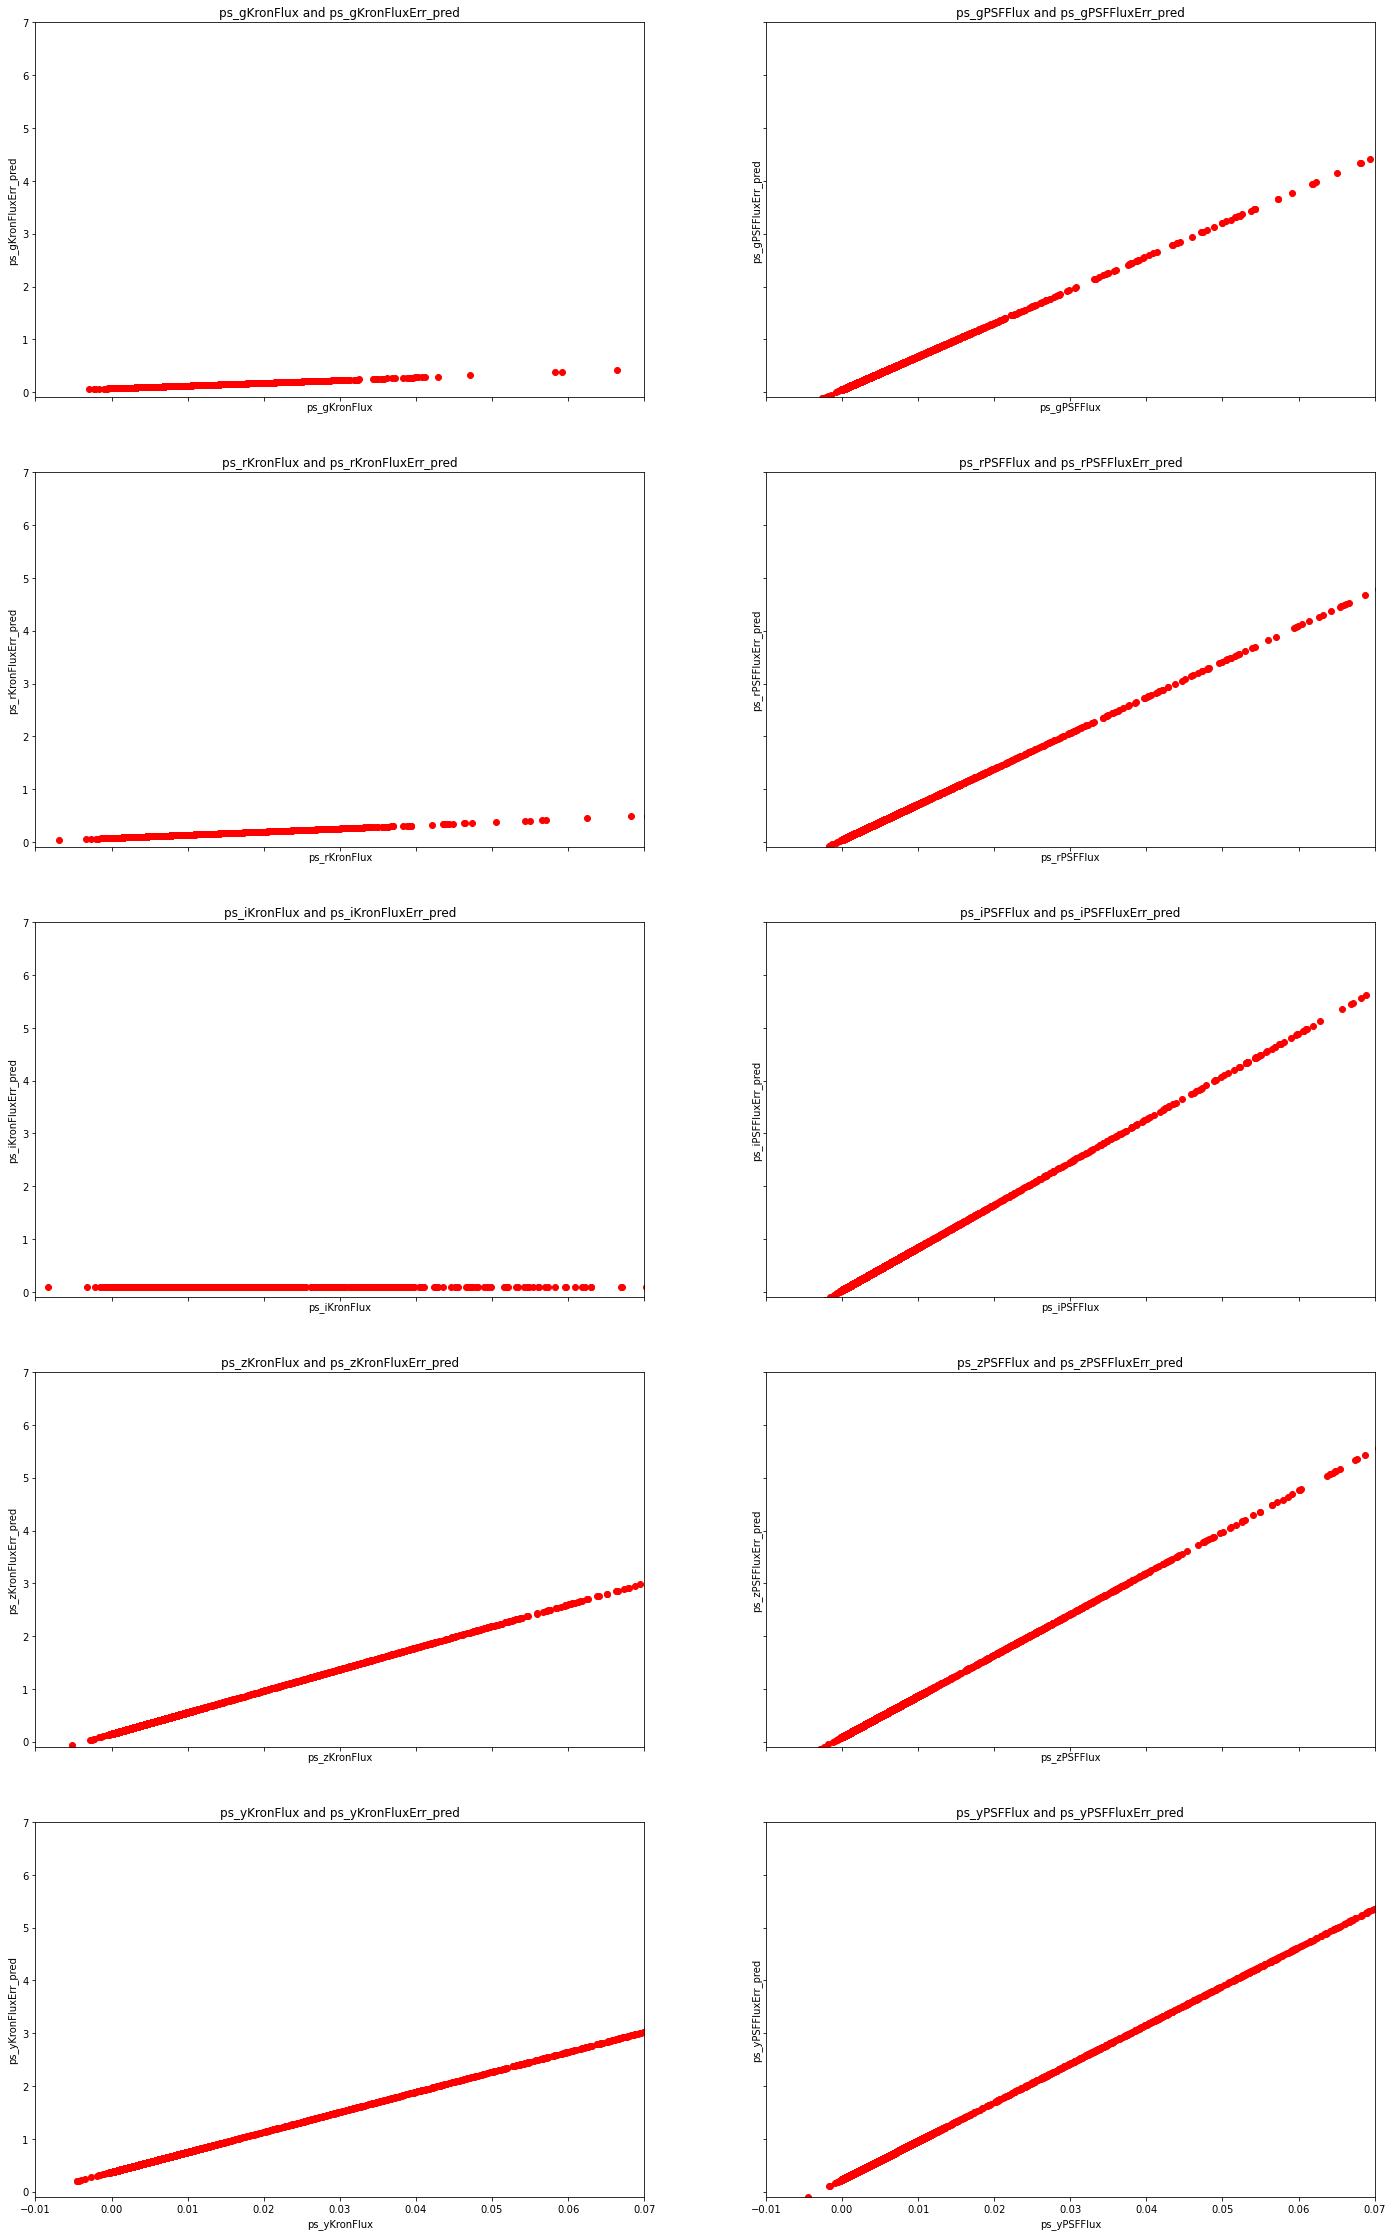

In [111]:
f, axes = plt.subplots(nrows = 5, ncols=2, figsize=(24, 40), sharex=True, sharey = True)
for i in range(len(feat) // 2):
    ax = axes[i % 5][i // 5]
    df1 = df[feat[i * 2 : i * 2 + 2]].dropna()
    X = df1[[feat[i * 2]]]
    y = df1[[feat[i * 2 + 1]]]
    reg = LinearRegression().fit(X, y)
    df1[feat[i * 2 + 1] + '_pred'] = reg.predict(X)
    plotik_ax(df1, feat[i * 2], feat[i * 2 + 1] + '_pred', ax)

In [ ]:
for i in range(len(feat) // 2):
    ax = axes[i % 5][i // 5]
    df1 = df[feat[i * 2 : i * 2 + 2]].dropna()
    
X = df1[[feat[i * 2]]]
y = df1[[feat[i * 2 + 1]]]
reg = LinearRegression().fit(X, y)
df1[feat[i * 2 + 1] + '_pred'] = reg.predict(X)
plotik_ax(df1, feat[i * 2], feat[i * 2 + 1] + '_pred', axes)